[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/KabirDabholkar/space-of-solutions-2D/blob/master/analysis_2Drnn.ipynb)

In [5]:
# Uncomment the next line to install package torchdiffeq
#! pip install torchdiffeq

"""
# Uncomment if running on colab
! rm -r space-of-solutions-2D
! git clone https://github.com/KabirDabholkar/space-of-solutions-2D
! cp space-of-solutions-2D/* .
#"""

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import matplotlib.gridspec as gridspec
import string
import seaborn as sns
import pandas as pd
import pickle as pkl
import torch
from torch import nn
from torchdiffeq import odeint
from sklearn.decomposition import PCA

from plot_tools import *
from rnn import *

In [2]:
def get_losses(net):
    net.method='dopri5'
    T=10
    net.dt=T
    X = net.integrate(T)
    end_x = torch.tensor([np.cos(90/180*np.pi),np.sin(90/180*np.pi)],device=net.device,dtype=net.dtype)[None,:,None] #
    losses = torch.sum((X[-1]-end_x)**2/2,(1,2))
    return losses

In [16]:
device = 'cpu'

net = torch.load('net_tanh4', map_location = device)
net.device = device
net.W.detach()
net.W.requires_grad=False

losses = get_losses(net)
goodidx = np.where(losses.detach().cpu().numpy()<1e-4)[0]
w=np.linalg.eigvals(net.W.detach().cpu().numpy())

goodnet = net.sample(goodidx)

def get_three_types_of_solutions(net):
    w=np.linalg.eigvals(net.W.detach().cpu().numpy())

    T=30
    net.method = 'rk4'
    net.dt = 1e-2
    samp = int(1/net.dt)
    X1=net.integrate(T).detach().cpu().numpy()
    
    q = np.mean( (X1[11*samp]-X1[10*samp])**2 ,(1,2))
    target_is_fp_idx = q.argmin()
    imthr =  0.1 #for tanh
    limit_cycle_idx = np.where ( (np.abs(w[:,0].imag) > imthr) * ((w.real>1).sum(1)==2) )[0][0] 
    origin_fp_idx = w.real.max(1).argmin()
    #origin_fp_idx = np.mean( X1[-1]**2 ,(1,2)).argmin()
    return [target_is_fp_idx,limit_cycle_idx,origin_fp_idx]
    
selectidx = get_three_types_of_solutions(goodnet)

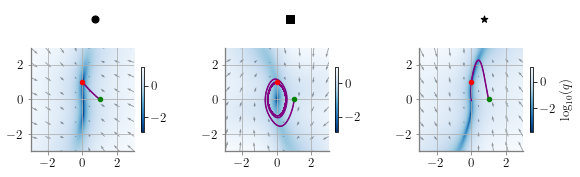

In [23]:
matplotlib.rcParams.update({'font.size': 13,
                            #'font.family':'sans-serif',
                            #'font.sans-serif':['Arial'],
                            'font.family': 'STIXGeneral',
                            'mathtext.fontset': 'stix',
                            'axes.titleweight':'bold'})
                            #'text.usetex': True
                            #'text.latex.preamble':r"""\usepackage{amsmath}
                            #                      \usepackage{amssymb}"""})

fig=plt.figure(constrained_layout=False,figsize=(9,3))
gs = fig.add_gridspec(2, 3, height_ratios = [2,9],left=0.1, right=0.9, bottom=0.2,
                        wspace=0.5)


def plot_DS(ax,net,idx,res1=8,res2=150,clabel='$\log_{10}(q)$'):
    x = np.linspace(-3,3,res1)
    X = np.stack(np.meshgrid(x,x),0).reshape(2,-1)[None]
    Xtor = torch.tensor(X,device = device)
    vec = net.sample([idx]).dxdt(0,Xtor).detach().cpu().numpy()
    ax.quiver(X[0,0],X[0,1],vec[0,0],vec[0,1],linewidths=1,alpha=0.4)
    
    
    x = net.sample([idx]).integrate(100).detach().cpu().numpy()
    samp = int(1/net.dt)
    ax.plot(x[:10*samp,0,0,0],x[:10*samp,0,1,0],zorder=2,color='purple')
    ax.plot(x[:,0,0,0],x[:,0,1,0],zorder=2,color='purple',lw=0.75)

    x = np.linspace(-3,3,res2)
    X = np.stack(np.meshgrid(x,x),0).reshape(2,-1)[None]
    Xtor = torch.tensor(X,device = device)
    vec = net.sample([idx]).dxdt(0,Xtor).detach().cpu().numpy()
    q = 0.5 * (vec**2).sum(1)[0].reshape(res2,res2)
    im = ax.imshow(np.log10(q),extent=[-3,3,3,-3],cmap='Blues_r')#,interpolation='nearest')
    c = fig.colorbar(im, ax = ax, shrink=0.6, label=clabel,ticks=[-2,0])# =||\dot x||^2
    ax.set_xlim(-3,3)
    ax.set_ylim(-3,3)
    
    ax.scatter(1,0,color='green',s=20,zorder=3)
    ax.scatter(0,1,color='red',s=20,zorder=3)

    ax.set_aspect('equal')
    ax.set_xticks(np.arange(-2,2.1,2))
    ax.set_yticks(np.arange(-2,2.1,2))
    ax_style(ax,spine_lims=[None,None,(-3,3),(-3,3)])
    ax.grid(zorder=1)
    return vec,X

markers= ['o','s','*']
for i,idx in enumerate(selectidx):
    ax = fig.add_subplot(gs[1,i])

    vec,X = plot_DS(ax,goodnet,idx,clabel=None if i<2 else '$\log_{10}(q)$')
    ax = fig.add_subplot(gs[0,i])
    ax_style(ax,keep=[])
    ax.scatter(0,0,marker=markers[i],color='black',s=50)
    ax.axis('off')
    
#fig.savefig("2Drnn_3solutions_symbols.png",dpi=200)

In [ ]:
def flatten(W):
    return W.reshape(W.shape[0],-1).detach().cpu().numpy()

def get_PCA(Wflat):
    P=PCA()
    P.fit(Wflat)
    return P

def gridPC12(P,xres=15,yres=10,lims=[[-6,6],[-5,5]]):
    x = np.linspace(*lims[0],xres)
    y = np.linspace(*lims[1],yres)
    X = np.stack(np.meshgrid(x,y),0).reshape(2,-1)
    X = np.concatenate([X,np.zeros(X.shape)[:1,:]],0)
    invX = P.inverse_transform(X.T)
    gridW = invX.reshape(-1,2,2)
    gridnet = smooth_rnn(W=torch.tensor(gridW),batches = gridW.shape[0])
    gridnet.dt=1e-2
    gridnet.method = 'rk4'
    return gridnet,X,(xres,yres),lims

Wflat = flatten(goodnet.sample(selectidx).W)
P = get_PCA(Wflat)

gridnet,X,res,lims = gridPC12(P,xres=600,yres=580)

bs=10
#losses = np.concatenate( [  get_losses(gridnet.sample(np.arange(i,i+bs))).detach().cpu().numpy() 
#                                                                      for i in range(0,gridnet.batches,bs) ] )
losses = get_losses(gridnet).detach().cpu().numpy() 
losses = losses.reshape(*res[::-1])

w = np.linalg.eigvals(gridnet.W.detach().cpu().numpy())
w = w.reshape(*res[::-1],w.shape[-1])

In [ ]:
overlay = True

fig,axs = plt.subplots(1,1,figsize = (6,5),sharey=True,sharex=True)
ax = axs

def plot_slice(ax,losses,w,anot_fs=22):
    im = ax.imshow(np.log10(losses),extent=lims[0]+lims[1][::-1],cmap='Purples_r')
    c = fig.colorbar(im,ax=ax,shrink=0.6, label=r'$\log_{10} \mathcal L$')
    ax.set_xlim(*lims[0])
    ax.set_ylim(*lims[1])
    ax.set_xlabel(r'$\tilde{W}_1$')
    ax.set_ylabel(r'$\tilde{W}_2$')

    origin_unst = w[:,:,:].real.max(2)>1
    rot = w[:,:,:].imag.max(2)>1e-2
    lim_cycle = rot * origin_unst
    nontrivFP = ~rot * origin_unst
    stable = ~origin_unst

    Z = np.zeros(losses.shape)
    Z[lim_cycle] = 1
    Z[nontrivFP] = 2

    #ax = axs

    if overlay:
        ax.contour(np.flipud(nontrivFP),levels=[0.5],colors='red',extent=lims[0]+lims[1][::-1],alpha=0.7,linewidths=.5)
        ax.contour(np.flipud(lim_cycle),levels=[0.5],colors='black',extent=lims[0]+lims[1][::-1],alpha=0.7,linestyles='dashed',linewidths=.5)
        #ax.contour(np.flipud(stable),levels=[0.5],colors='green',extent=lims[0]+lims[1][::-1],alpha=0.7,linestyles='dotted',linewidths=.5)
        #ax.contourf(np.flipud(Z),levels=[0.5,1.5,2.5],colors=['black','red','orange'],extent=lims[0]+lims[1][::-1],alpha=0.2)
        ax.annotate('LC',(-3,-2.5),va='center',ha='center',fontsize=anot_fs)
        ax.annotate('LC',(4,-1.5),va='center',ha='center',fontsize=anot_fs)
        ax.annotate('Non-trivial\nFP',(-0.5,2.1),va='center',ha='center',fontsize=anot_fs,c='red')
        ax.annotate('Stable\nOrigin',(-4.1,-0.5),va='center',ha='center',fontsize=anot_fs,c='green')
        ax.annotate('Stable\nOrigin',(4,2.5),va='center',ha='center',fontsize=anot_fs,c='green')


    #ax.set_xlabel('PC 1')
    #ax.set_ylabel('PC 2')
    ax.set_xticks([])#ax.set_xlim(*lims[1])
    ax.set_yticks([])#ax.set_xlim(*lims[1])

    pcW = P.transform(Wflat)
    markers= ['o','s','*']
    for i in range(3):
        ax.scatter(pcW[i,0],pcW[i,1],c='black',s=30,marker=markers[i])
    ax_style(ax)
    return ax

plot_slice(ax,losses,w)
#fig.savefig('losslandscape.png',dpi=250)